# Modelling

Finding the ideal model for recommending restuarants to users

In [2]:
import os
import time
import json
import pickle
from collections import Counter
import collections

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# import databricks.koalas as ks

import pyspark
from pyspark.sql import SparkSession
import pandas as pd

# Setup a SparkSession
spark = SparkSession.builder.getOrCreate()

import pandas_profiling
# df.profile_report(style={'full_width':True})
# df.profile_report(title='Pandas Profiling Report')

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
plt.style.use('seaborn')
font = {'size':16}
import seaborn as sns

from sklearn.metrics import mean_absolute_error

import surprise
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise import KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline
from surprise import SVD, SVDpp, NMF
from surprise import accuracy
from surprise import SlopeOne, CoClustering
from surprise.model_selection import train_test_split

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.simplefilter('ignore')

In [2]:
def notify(title, text):
    os.system("""
              osascript -e 'display notification "{}" with title "{}"'
              """.format(text, title))

notify("Test Title", "Heres an alert")

## Reading in AZNV dataframe

In [21]:
AZNV_df = pd.read_pickle('../data/AZNV_df.p')
print(AZNV_df.shape)
AZNV_df.head(2)

(1818490, 32)


,business_id,name_x,address,city,state,postal_code,latitude,longitude,stars_x,review_count_x,is_open,attributes,categories,hours,review_id,user_id,stars_y,useful,funny,cool,text,date,name_y,review_count_y,yelping_since,friends,fans,average_stars,likes,compliments,elite_years,hotel?
0,vx4YAA02Qz6khRD1fZ1MFA,Ping Pang Pong,4000 W Flamingo Rd,Las Vegas,NV,89103,36.116901,-115.193512,3.5,1005,1,"{'RestaurantsPriceRange2': '2', 'BusinessAccep...","[Cantonese, Seafood, Dim Sum, Restaurants, Chi...","{'Monday': '10:0-3:0', 'Tuesday': '10:0-3:0', ...",FwiJ7DQ3a9cBwp1OYlP5VA,A0kENtCCoVT3m7T35zb2Vg,2.0,0,0,0,There are so many good reviews of this place o...,2010-04-02 20:37:54,Anastasia,348,2009-02-15 16:45:34,"BBY1Alonk5V0OLgk_G0rNQ, TY7QgNKJEhvo1zCULlT9Rg...",9,3.66,619,38,3,0
1,glTBzDHv9wNhEsZa4bQrOA,CatHouse Boutique Nightclub,3900 Las Vegas Blvd S,Las Vegas,NV,89119,36.094822,-115.173216,3.0,178,0,"{'OutdoorSeating': 'False', 'BusinessAcceptsCr...","[Restaurants, Nightlife, Lounges, American (Ne...","{'Monday': '17:0-4:0', 'Tuesday': '17:0-4:0', ...",7ynnTyXiuIWHDkktHsdm4Q,A0kENtCCoVT3m7T35zb2Vg,2.0,1,1,0,"Restaurant-only review; based on that, they wo...",2009-02-16 14:53:11,Anastasia,348,2009-02-15 16:45:34,"BBY1Alonk5V0OLgk_G0rNQ, TY7QgNKJEhvo1zCULlT9Rg...",9,3.66,619,38,3,0


In [4]:
np.mean(AZNV_df['stars_x'])

3.7818712228277307

### Create numerical features for IDs

In [96]:
user_labels, user_uniques = pd.factorize(AZNV_df['user_id'])
business_labels, business_uniques = pd.factorize(AZNV_df['business_id'])

AZNV_df['userid'] = user_labels
AZNV_df['businessid'] = business_labels

### Create pandas and spark DF for recommender models

In [6]:
pandas_df = AZNV_df[['userid', 'businessid', 'stars_y']]
pandas_df = pandas_df.rename(columns={"businessid": "restaurantid", "stars_y":"rating"})

pandas_df.head()

,userid,restaurantid,rating
0,0,0,2.0
1,0,1,2.0
2,0,2,1.0
3,0,3,4.0
4,0,4,5.0


In [91]:
pandas_df.to_pickle('../data/model_pandas_df.p')

In [3]:
pandas_df = pd.read_pickle('../data/model_pandas_df.p')
pandas_df.head(2)

,userid,restaurantid,rating
0,0,0,2.0
1,0,1,2.0


In [93]:
spark_df = spark.createDataFrame(pandas_df)

## ALS Model - Base Model

Train ALS model using np.mean of ratings

In [94]:
train, test = spark_df.randomSplit([0.8, 0.2], seed=0)

train.show(5)

train.count()

+------+------------+------+
|userid|restaurantid|rating|
+------+------------+------+
|     0|           1|   2.0|
|     0|           2|   1.0|
|     0|           4|   5.0|
|     0|           6|   5.0|
|     0|           7|   3.0|
+------+------------+------+
only showing top 5 rows



1455147

In [95]:
train_with_mean = train.toPandas()
train_with_mean['rating'] = np.mean(train_with_mean['rating'])
train_with_mean = spark.createDataFrame(train_with_mean)
train_with_mean.show(2)

+------+------------+------------------+
|userid|restaurantid|            rating|
+------+------------+------------------+
|     0|           1|3.7893498045214677|
|     0|           2|3.7893498045214677|
+------+------------+------------------+
only showing top 2 rows



In [96]:
from pyspark.ml.recommendation import ALS
als_model = ALS(
    itemCol='restaurantid',
    userCol='userid',
    ratingCol='rating',
    nonnegative=True,    
    regParam=0.1,
    rank=10) 

recommender = als_model.fit(train_with_mean)

print('ALS model has been fitted on train_with_mean data.')

ALS model has been fitted on train_with_mean data.


In [97]:
# look at a random prediction

data = [(0, 3)]
columns = ('userid', 'restaurantid')
one_row_spark_df = spark.createDataFrame(data, columns)
user_factor_df = recommender.userFactors.filter('id = 1')
item_factor_df = recommender.itemFactors.filter('id = 100')
user_factors = user_factor_df.collect()[0]['features']
item_factors = item_factor_df.collect()[0]['features']
recommender.transform(one_row_spark_df).show()

+------+------------+----------+
|userid|restaurantid|prediction|
+------+------------+----------+
|     0|           3| 3.6294148|
+------+------------+----------+



In [98]:
predictions = recommender.transform(test)
predictions.describe().show()

+-------+-----------------+------------------+------------------+----------+
|summary|           userid|      restaurantid|            rating|prediction|
+-------+-----------------+------------------+------------------+----------+
|  count|           363343|            363343|            363343|    363343|
|   mean|67019.54313692571| 4357.848828792628|3.7901789768896057|       NaN|
| stddev|56886.59800722874|3628.5879309853876|1.3181072931108382|       NaN|
|    min|                0|                 0|               1.0| 2.9763389|
|    max|           203358|             14796|               5.0|       NaN|
+-------+-----------------+------------------+------------------+----------+



In [99]:
# Dump the predictions to Pandas DataFrames to make our final calculations easier
predictions_df = predictions.toPandas()
train_df = train.toPandas()

In [100]:
# Fill any missing values with the mean rating
predictions_df = predictions.toPandas().fillna(train_df['rating'].mean())

In [101]:
# Calculate Root Mean Squared Error (RMSE)

predictions_df['squared_error'] = (predictions_df['rating'] - predictions_df['prediction'])**2

rmse = np.sqrt(sum(predictions_df['squared_error']) / len(predictions_df))

print('RMSE of base (train data with mean): {}'.format(rmse))

RMSE of base (train data with mean): 1.3274137815483629


In [104]:
# Calculate Mean Absolute Error (MAE)

y_true = predictions_df['rating']
y_pred = predictions_df['prediction']
mae = mean_absolute_error(y_true, y_pred)

print('MAE of base (train data with mean): {}'.format(mae))

MAE of base (train data with mean): 1.141648958873738


### RMSE 1.3274 is the score to beat!

Using RMSE because it punishes error more highly than MAE

## ALS on train dataset

In [13]:
from pyspark.ml.recommendation import ALS
als_model = ALS(
    itemCol='restaurantid',
    userCol='userid',
    ratingCol='rating',
    nonnegative=True,    
    regParam=0.1,
    rank=10) 

recommender = als_model.fit(train)

print('ALS model has been fitted on train data.')

ALS model has been fitted on train data.


In [14]:
predictions = recommender.transform(test)
predictions_df = predictions.toPandas()
train_df = train.toPandas()
predictions_df = predictions.toPandas().fillna(train_df['rating'].mean())

predictions_df['squared_error'] = (predictions_df['rating'] - predictions_df['prediction'])**2

rmse = np.sqrt(sum(predictions_df['squared_error']) / len(predictions_df))

print('RMSE of train: {}'.format(rmse))

RMSE of train: 1.4427868868935185


In [15]:
predictions_df.head()

,userid,restaurantid,rating,prediction,squared_error
0,29054,148,5.0,4.522486,0.228020
1,14514,148,3.0,2.615818,0.147596
2,122710,148,4.0,3.924699,0.005670
3,14958,148,3.0,3.699966,0.489952
4,106608,148,3.0,2.643519,0.127078


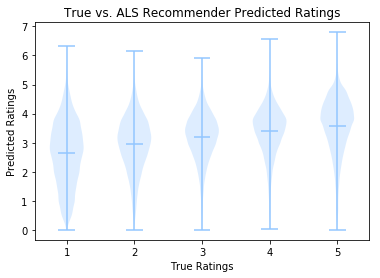

In [16]:
# Create array of predictions for violinplot
data = [predictions_df['prediction'][predictions_df['rating'] == rating].values for rating in range(1, 6)]
plt.violinplot(data, range(1,6), showmeans=True, )
plt.xlabel('True Ratings')
plt.ylabel('Predicted Ratings')
plt.title('True vs. ALS Recommender Predicted Ratings')
plt.show();

### Model turned out to be worse than the base...

## Collaborative Filtering

Item-Item Collaborative Filtering (IBCF) measures the similarity between the items that target users rates/ interacts with and other items

#### Advantages of item-based filtering over user-based filtering :

* Computationally less expensive : When users >> items, It makes sense to use item-based filtering in this case. 
* Item-item is less sparse than user-user matrix
* A famous example of item-based filtering is <a href = 'https://www.cs.umd.edu/~samir/498/Amazon-Recommendations.pdf'>Amazon’s recommendation engine</a>.

## Surprise library

<a href='http://surpriselib.com/'>Surprise library</a> is a great tool for building and analyzing recommender models.
<br><br>
Thank you to bmanohar16's work used as reference

### Split data into train/test

In [17]:
pandas_df.shape

(1818490, 3)

In [18]:
print('Unique Users    :', pandas_df.userid.nunique())
print('Unique Restaurant :', pandas_df.restaurantid.nunique())
print('Unique Ratings  :', pandas_df.rating.nunique())

Unique Users    : 203359
Unique Restaurant : 14797
Unique Ratings  : 5


In [63]:
# Set Rating Scale
reader = Reader(rating_scale=(1, 5))

# Load data with rating scale
data = Dataset.load_from_df(pandas_df, reader)

In [35]:
trainset, testset = train_test_split(data, test_size=.25, random_state=0)

### KNN Basic

computes similiarities between item-item where k=40 (down to 1 if less than 40)

In [7]:
start = time.time()

sim_options = {'name': 'cosine',
               'user_based': False  # compute  similarities between items
               }
algo = KNNBasic(sim_options=sim_options)

knnbasic_cv = cross_validate(algo, data, cv=5, n_jobs=-1, verbose=True)

end = time.time()
print('\nthis took {:.2f} seconds to run'.format(end-start))
notify("Notification", "Model is complete")

Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.3620  1.3590  1.3630  1.3586  1.3600  1.3605  0.0017  
MAE (testset)     1.0236  1.0218  1.0249  1.0202  1.0224  1.0226  0.0016  
Fit time          30.83   31.05   30.42   31.61   28.49   30.48   1.07    
Test time         21.81   20.72   22.87   19.97   18.51   20.78   1.50    
this took 235.93 seconds to run


### KNNWithMeans

A basic collaborative filtering algorithm, taking into account the mean ratings of each user.
<br>
* Using an item-item similiarity measure with k between 1 and 40

In [8]:
start = time.time()

sim_options = {'name': 'cosine',
               'user_based': False  # compute  similarities between items
               }
algo = KNNWithMeans(sim_options=sim_options)

knnmeans_cv = cross_validate(algo, data, cv=5, n_jobs=-1, verbose=True)

end = time.time()
print('\nthis took {:.2f} seconds to run'.format(end-start))
notify("Notification", "Model is complete")

Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2530  1.2540  1.2519  1.2546  1.2522  1.2531  0.0010  
MAE (testset)     0.9448  0.9454  0.9445  0.9462  0.9435  0.9449  0.0009  
Fit time          28.53   31.86   29.81   29.90   29.04   29.83   1.13    
Test time         24.83   21.97   21.61   20.79   20.49   21.94   1.54    

this took 230.03 seconds to run


NameError: name 'notify' is not defined

### KNNWithZScore

A basic collaborative filtering algorithm, taking into account
the z-score normalization of each user.

In [11]:
start = time.time()

sim_options = {'name': 'cosine',
               'user_based': False  # compute  similarities between items
               }
algo = KNNWithZScore(sim_options=sim_options)

knnz_cv = cross_validate(algo, data, cv=5, n_jobs=-1, verbose=True)

end = time.time()
print('\nthis took {:.2f} seconds to run'.format(end-start))
notify("Notification", "Model is complete")

Evaluating RMSE, MAE of algorithm KNNWithZScore on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2524  1.2543  1.2562  1.2551  1.2549  1.2546  0.0012  
MAE (testset)     0.9397  0.9414  0.9441  0.9418  0.9417  0.9417  0.0014  
Fit time          32.71   37.81   36.07   34.22   31.72   34.50   2.21    
Test time         30.26   27.80   26.57   24.80   23.21   26.53   2.43    

this took 255.27 seconds to run


TypeError: notify() missing 2 required positional arguments: 'subtitle' and 'message'

### KNNBaseline

A basic collaborative filtering algorithm taking into account a baseline rating.



In [10]:
start = time.time()

sim_options = {'name': 'cosine',
               'shrinkage': 0,  # no shrinkage
               'user_based': False  # compute  similarities between items
               }
algo = KNNBaseline(sim_options=sim_options)

knn_baseline = cross_validate(algo, data, cv=5, n_jobs=-1, verbose=True)

end = time.time()
print('\nthis took {:.2f} seconds to run'.format(end-start))
notify("Notification", "Model is complete")

Evaluating RMSE, MAE of algorithm KNNBaseline on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2562  1.2542  1.2526  1.2500  1.2562  1.2538  0.0023  
MAE (testset)     0.9484  0.9472  0.9464  0.9438  0.9486  0.9469  0.0017  
Fit time          32.35   41.32   38.04   34.44   31.50   35.53   3.67    
Test time         37.84   35.46   31.70   25.59   24.23   30.96   5.33    

this took 260.60 seconds to run


### Matrix Factorization Based Algorithms

In [13]:
start = time.time()

svd_cv = cross_validate(SVD(), data, cv=5, n_jobs=-1, verbose=True)

end = time.time()
print('\nthis took {:.2f} seconds to run'.format(end-start))
notify("Notification", "Model is complete")

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.1934  1.1932  1.1936  1.1928  1.1940  1.1934  0.0004  
MAE (testset)     0.9465  0.9464  0.9477  0.9469  0.9473  0.9470  0.0005  
Fit time          110.08  114.72  112.34  105.94  101.61  108.94  4.67    
Test time         5.15    4.39    3.91    3.82    3.75    4.21    0.52    

this took 309.10 seconds to run


TypeError: notify() missing 2 required positional arguments: 'subtitle' and 'message'

In [22]:
start = time.time()

svdpp_cv = cross_validate(SVDpp(), data, cv=5, n_jobs=-1, verbose=True)

end = time.time()
print('\nthis took {:.2f} seconds to run'.format(end-start))
notify("Notification", "Model is complete")

Evaluating RMSE, MAE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.1993  1.1993  1.1989  1.2015  1.1970  1.1992  0.0014  
MAE (testset)     0.9461  0.9471  0.9464  0.9475  0.9454  0.9465  0.0007  
Fit time          1414.89 1418.26 1417.86 1434.24 1408.60 1418.77 8.47    
Test time         31.60   31.58   21.10   19.11   19.95   24.67   5.69    

this took 1637.75 seconds to run


In [23]:
start = time.time()

nmf_cv = cross_validate(NMF(), data, cv=5, n_jobs=-1, verbose=True)

end = time.time()
print('\nthis took {:.2f} seconds to run'.format(end-start))
notify("Notification", "Model is complete")

Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.3246  1.3255  1.3246  1.3258  1.3243  1.3250  0.0006  
MAE (testset)     1.0165  1.0177  1.0169  1.0184  1.0172  1.0173  0.0007  
Fit time          119.38  124.66  126.34  121.72  108.79  120.18  6.18    
Test time         4.10    3.58    3.24    3.13    3.11    3.43    0.38    

this took 297.22 seconds to run


### Other Collaborative Filtering Algorithms

In [25]:
start = time.time()

slope_cv = cross_validate(SlopeOne(), data, cv=5, n_jobs=-1, verbose=True)

end = time.time()
print('\nthis took {:.2f} seconds to run'.format(end-start))
notify("Notification", "Model is complete")

Evaluating RMSE, MAE of algorithm SlopeOne on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.3077  1.3083  1.3050  1.3073  1.3042  1.3065  0.0016  
MAE (testset)     0.9811  0.9808  0.9797  0.9803  0.9792  0.9802  0.0007  
Fit time          14.29   14.33   14.50   19.49   15.18   15.56   1.99    
Test time         14.42   14.24   15.73   16.36   16.99   15.55   1.07    

this took 223.36 seconds to run


In [26]:
start = time.time()

coclus_cv = cross_validate(CoClustering(), data, cv=5, n_jobs=-1, verbose=True)

end = time.time()
print('\nthis took {:.2f} seconds to run'.format(end-start))
notify("Notification", "Model is complete")

Evaluating RMSE, MAE of algorithm CoClustering on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2726  1.2766  1.2751  1.2793  1.2711  1.2749  0.0029  
MAE (testset)     0.9500  0.9534  0.9528  0.9556  0.9505  0.9525  0.0020  
Fit time          36.92   35.66   38.36   35.02   32.95   35.78   1.82    
Test time         3.52    3.17    3.42    3.09    3.17    3.27    0.17    

this took 231.57 seconds to run


## Comparison of all algorithms on RMSE and MAE

#### Saving RMSE and MAE scores

In [61]:
save_scores = [knnbasic_cv, knnmeans_cv, knnz_cv, svd_cv, svdpp_cv, nmf_cv, slope_cv, coclus_cv]
outfile = '../data/RMSE_MAE_scores.png'

with open('outfile', 'wb') as fp:
    pickle.dump(save_scores, fp)

#### Reading back RMSE and MAE scores

In [11]:
outfile = '../data/RMSE_MAE_scores.png'

with open ('outfile', 'rb') as fp:
    save_scores = pickle.load(fp)

#### Show results

In [182]:
print('Algorithm\t RMSE\t\t MAE')
print('--------------', '\t', '------', '\t', '------')
print('ALS with Means', '\t', round(rmse, 4), '\t', round(mae, 4))
print()
print('KNN Basic', '\t', round(knnbasic_cv['test_rmse'].mean(), 4), '\t', round(knnbasic_cv['test_mae'].mean(), 4))
print('KNN Means', '\t', round(knnmeans_cv['test_rmse'].mean(), 4), '\t', round(knnmeans_cv['test_mae'].mean(), 4))
print('KNN ZScore', '\t', round(knnz_cv['test_rmse'].mean(), 4), '\t', round(knnz_cv['test_mae'].mean(), 4))
print()
print('SVD', '\t\t', round(svd_cv['test_rmse'].mean(), 4), '\t', round(svd_cv['test_mae'].mean(), 4))
print('SVDpp', '\t\t', round(svdpp_cv['test_rmse'].mean(), 4), '\t', round(svdpp_cv['test_mae'].mean(), 4))
print('NMF', '\t\t', round(nmf_cv['test_rmse'].mean(), 4), '\t\t', round(nmf_cv['test_mae'].mean(), 4))
print()
print('SlopeOne', '\t', round(slope_cv['test_rmse'].mean(), 4), '\t', round(slope_cv['test_mae'].mean(), 4))
print('CoClustering', '\t', round(coclus_cv['test_rmse'].mean(), 4), '\t', round(coclus_cv['test_mae'].mean(), 4))

Algorithm	 RMSE		 MAE
-------------- 	 ------ 	 ------
ALS with Means 	 1.3274 	 1.1416

KNN Basic 	 1.3605 	 1.0226
KNN Means 	 1.2531 	 0.9449
KNN ZScore 	 1.2546 	 0.9417

SVD 		 1.1934 	 0.947
SVDpp 		 1.1992 	 0.9465
NMF 		 1.325 		 1.0173

SlopeOne 	 1.3065 	 0.9802
CoClustering 	 1.2749 	 0.9525


### Added KNN Baseline model after restarting notebook

inserting data manually into charts

In [16]:
print('rmse: ', round(knn_baseline['test_rmse'].mean(), 4))
print('mae: ', round(knn_baseline['test_mae'].mean(), 4))

rmse:  1.2538
mae:  0.9469


In [18]:
print('Algorithm\t RMSE\t\t MAE')
print('--------------', '\t', '------', '\t', '------')
print('ALS with Means', '\t', 1.3274, '\t', 1.1416)
print()
print('KNN Basic', '\t', 1.3605, '\t', 1.0226)
print('KNN Means', '\t', 1.2531, '\t', 0.9449)
print('KNN ZScore', '\t', 1.2546, '\t', 0.9417)
print('KNN Baseline', '\t', 1.2538, '\t', 0.9469)
print()
print('SVD', '\t\t', 1.1934, '\t', 0.947)
print('SVDpp', '\t\t', 1.1992, '\t', 0.9465)
print('NMF', '\t\t', 1.325, '\t\t', 1.0173)
print()
print('SlopeOne', '\t', 1.3065, '\t', 0.9802)
print('CoClustering', '\t', 1.2749, '\t', 0.9525)

Algorithm	 RMSE		 MAE
-------------- 	 ------ 	 ------
ALS with Means 	 1.3274 	 1.1416

KNN Basic 	 1.3605 	 1.0226
KNN Means 	 1.2531 	 0.9449
KNN ZScore 	 1.2546 	 0.9417
KNN Baseline 	 1.2538 	 0.9469

SVD 		 1.1934 	 0.947
SVDpp 		 1.1992 	 0.9465
NMF 		 1.325 		 1.0173

SlopeOne 	 1.3065 	 0.9802
CoClustering 	 1.2749 	 0.9525


### Plotting RMSE / MAE via bar graph

In [ ]:
x_algo = ['KNN Basic', 'KNN Means', 'KNN ZScore', 'KNN Baseline', 'SVD', 'SVDpp', 'NMF', 'SlopeOne', 'CoClustering']
all_algos_cv = [knnbasic_cv, knnmeans_cv, knnz_cv, knn_baseline, ksvd_cv, svdpp_cv, nmf_cv, slope_cv, coclus_cv]

rmse_cv = [round(res['test_rmse'].mean(), 4) for res in all_algos_cv]
mae_cv = [round(res['test_mae'].mean(), 4) for res in all_algos_cv]

# manually adding base score data
x_algo = ['Base [ALS-Means]']+x_algo
rmse_cv = [1.3274]+rmse_cv
mae_cv = [1.1416]+mae_cv

In [68]:
## hardcoded rmse
x_algo = ['Base [ALS-Means]', 'KNN Basic', 'KNN Means', 'KNN ZScore', 'KNN Baseline', 'SVD', 'SVDpp', 'NMF', 'SlopeOne', 'CoClustering']
rmse_cv = [1.3274, 1.3605, 1.2531, 1.2546, 1.2538, 1.1934, 1.1992, 1.325, 1.3065, 1.2749]

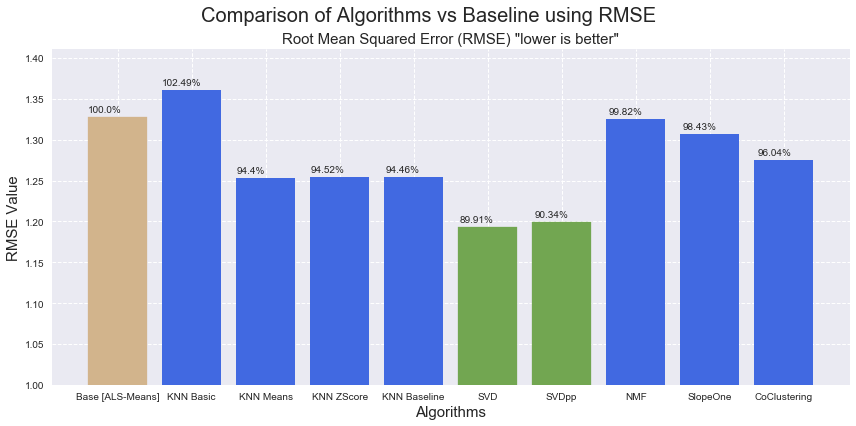

In [141]:
fig, ax = plt.subplots(1,1, figsize=(12,6))
fig.suptitle('Comparison of Algorithms vs Baseline using RMSE', fontsize=20, verticalalignment='top')
ax.set_title('Root Mean Squared Error (RMSE) "lower is better"', loc='center', fontsize=15)
c = ax.bar(x_algo, rmse_cv, label='RMSE', color='royalblue')
c[0].set_color('tan')
c[5].set_color('#72A651')
c[6].set_color('#72A651')
ax.set_ylim(bottom=1.0, top=max(rmse_cv)+.05)  
ax.set_xlabel('Algorithms', fontsize=15)
ax.set_ylabel('RMSE Value', fontsize=15)
ax.grid(ls='dashed')

# annotate bar graph 1
base0=1.3274
percent0 = [round(n/base0*100,2) for n in rmse_cv]
for i,p in enumerate(ax.patches):
    ax.annotate(str(percent0[i])+'%', (p.get_x() * 1.005, p.get_height() * 1.005))

plt.tight_layout()
fig.subplots_adjust(top=.88)
plt.savefig('../img/rmse_barchart.png', dpi=350, alpha=0)
plt.show();

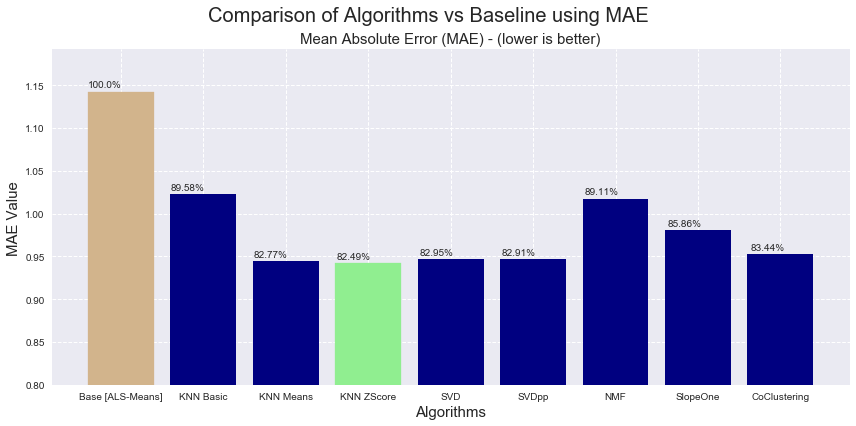

In [387]:
# ax[1].set_title('Comparison of Algorithms on MAE', loc='center', fontsize=15)
fig, ax = plt.subplots(1,1, figsize=(12,6))
fig.suptitle('Comparison of Algorithms vs Baseline using MAE', fontsize=20, verticalalignment='top')
ax.set_title('Mean Absolute Error (MAE) - (lower is better)', loc='center', fontsize=15)
c = ax.bar(x_algo, mae_cv, label='MAE', color='navy')
c[0].set_color('tan')
c[3].set_color('lightgreen')
ax.set_ylim(bottom=0.8, top=max(mae_cv)+.05)  
ax.set_xlabel('Algorithms', fontsize=15)
ax.set_ylabel('MAE Value', fontsize=15)
ax.grid(ls='dashed')

# annotate bar graph 2
base1=1.1416
percent1 = [round(n/base1*100,2) for n in mae_cv]
for i,p in enumerate(ax.patches):
    ax.annotate(str(percent1[i])+'%', (p.get_x() * 1.005, p.get_height() * 1.005))

plt.tight_layout()
fig.subplots_adjust(top=.88)
plt.savefig('../img/mae_barchart.png', dpi=350, alpha=0)
plt.show();

### Plotting RMSE/MAE via plt.plot

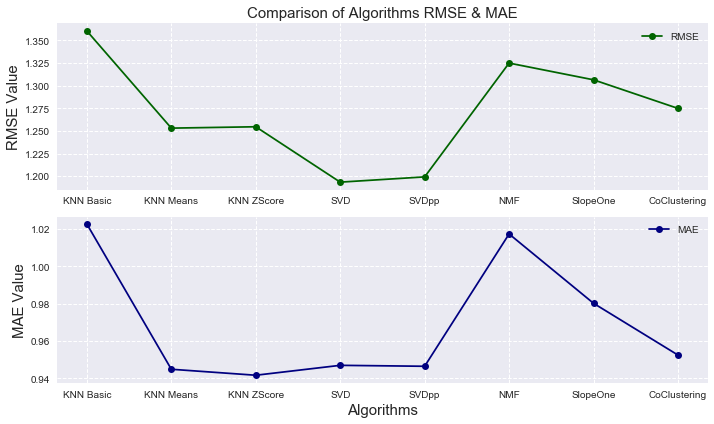

In [251]:
x_algo = ['KNN Basic', 'KNN Means', 'KNN ZScore', 'SVD', 'SVDpp', 'NMF', 'SlopeOne', 'CoClustering']
all_algos_cv = [knnbasic_cv, knnmeans_cv, knnz_cv, svd_cv, svdpp_cv, nmf_cv, slope_cv, coclus_cv]

rmse_cv = [round(res['test_rmse'].mean(), 4) for res in all_algos_cv]
mae_cv = [round(res['test_mae'].mean(), 4) for res in all_algos_cv]

fig, ax = plt.subplots(2,1, figsize=(10,6))
ax[0].set_title('Comparison of Algorithms RMSE & MAE', loc='center', fontsize=15)
ax[0].plot(x_algo, rmse_cv, label='RMSE', color='darkgreen', marker='o')
# ax[0].set_xlabel('Algorithms', fontsize=15)
ax[0].set_ylabel('RMSE Value', fontsize=15)
ax[0].legend()
ax[0].grid(ls='dashed')

# ax[1].set_title('Comparison of Algorithms on MAE', loc='center', fontsize=15)
ax[1].plot(x_algo, mae_cv, label='MAE', color='navy', marker='o')
ax[1].set_xlabel('Algorithms', fontsize=15)
ax[1].set_ylabel('MAE Value', fontsize=15)
ax[1].legend()
ax[1].grid(ls='dashed')

plt.tight_layout()
plt.savefig('../img/rmse_mae_plotchart.png', dpi=300, transparency=True)
plt.show();

## Evaluation Results

<b>Best RMSE</b>: SVD
<br>
<b>Best MAE</b>: KNN ZScore

<font color='green'><h2>Winner SVD & SVD++!! </h2></font>

This is according to our metric RMSE.

However SVD and SVDpp both give good results, let's tune the hyperparameters to find the best RMSE score

## Tune hyperparameters using GridSearchCV

In [78]:
svd_param_grid = {'n_epochs': [5, 10], 
                  'lr_all': [0.007, 0.009, 0.01],
                  'reg_all': [0.2, 0.5]}

start = time.time()

svdpp_gs = GridSearchCV(SVD, svd_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=-1, joblib_verbose=2)
svdpp_gs.fit(data)

end = time.time()
print('svdpp_gs took {:.2f} seconds'.format(end-start))
notify("Notification", "Model is complete")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 12.5min


svdpp_gs took 2920.02 seconds


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 48.3min finished


In [79]:
print('SVDpp - RMSE:', round(svdpp_gs.best_score['rmse'], 4), '- MAE:', round(svdpp_gs.best_score['mae'], 4))

SVDpp - RMSE: 1.1775 - MAE: 0.9439


In [80]:
svd_param_grid = {'n_epochs': [5, 10], 
                  'lr_all': [0.007, 0.009, 0.01],
                  'reg_all': [0.2, 0.5]}

start = time.time()

svd_gs = GridSearchCV(SVD, svd_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=-1, joblib_verbose=2)
svd_gs.fit(data)

end = time.time()
print('svd_gs took {:.2f} seconds'.format(end-start))
notify("Notification", "Model is complete")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 12.5min


svd_gs took 1830.10 seconds


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 30.1min finished


In [81]:
print('SVD   - RMSE:', round(svd_gs.best_score['rmse'], 4), '- MAE:', round(svd_gs.best_score['mae'], 4))

SVD   - RMSE: 1.1776 - MAE: 0.944


In [295]:
x = svdpp_gs.cv_results['params']
y1 = svdpp_gs.cv_results['mean_test_rmse']
y2 = svdpp_gs.cv_results['mean_test_mae']

y3 = svd_gs.cv_results['mean_test_rmse']
y4 = svd_gs.cv_results['mean_test_mae']

In [305]:
x = [str(x1) for x1 in x]
x

["{'n_epochs': 5, 'lr_all': 0.007, 'reg_all': 0.2}",
 "{'n_epochs': 5, 'lr_all': 0.007, 'reg_all': 0.5}",
 "{'n_epochs': 5, 'lr_all': 0.009, 'reg_all': 0.2}",
 "{'n_epochs': 5, 'lr_all': 0.009, 'reg_all': 0.5}",
 "{'n_epochs': 5, 'lr_all': 0.01, 'reg_all': 0.2}",
 "{'n_epochs': 5, 'lr_all': 0.01, 'reg_all': 0.5}",
 "{'n_epochs': 10, 'lr_all': 0.007, 'reg_all': 0.2}",
 "{'n_epochs': 10, 'lr_all': 0.007, 'reg_all': 0.5}",
 "{'n_epochs': 10, 'lr_all': 0.009, 'reg_all': 0.2}",
 "{'n_epochs': 10, 'lr_all': 0.009, 'reg_all': 0.5}",
 "{'n_epochs': 10, 'lr_all': 0.01, 'reg_all': 0.2}",
 "{'n_epochs': 10, 'lr_all': 0.01, 'reg_all': 0.5}"]

### Graphing the GridSearchCV results

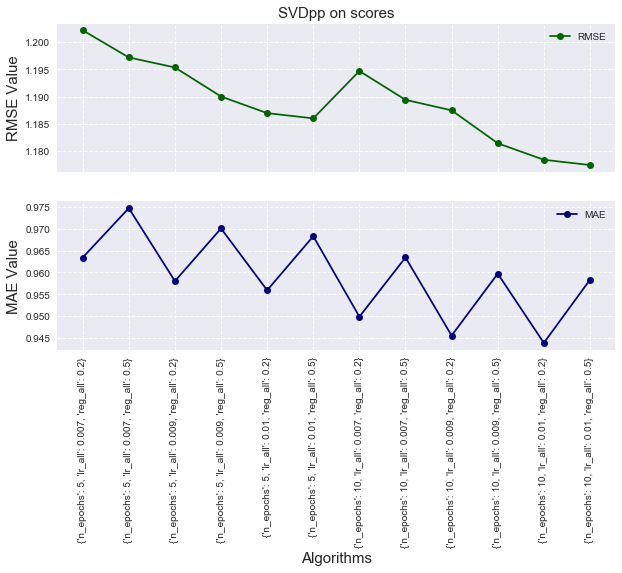

In [317]:
index = [1, 3, 5, 7, 9, 11, 0, 2, 4, 6, 8, 10]

xx = []
yy = []
for i, j in enumerate(x):
    xx = xx+[x[index[i]]]
    yy = yy+[y1[index[i]]]

fig, ax = plt.subplots(2,1, figsize=(10,6))
ax[0].set_title('SVDpp on scores', loc='center', fontsize=15)
ax[0].plot([str(x1) for x1 in xx], yy, label='RMSE', color='darkgreen', marker='o')
ax[0].set_xticklabels(['','','','','',''])
# ax[0].barh([str(x1) for x1 in x], y1)
# ax[0].set_xlabel('Algorithms', fontsize=15)
ax[0].set_ylabel('RMSE Value', fontsize=15)
ax[0].legend()
ax[0].grid(ls='dashed')

# ax[1].set_title('SVDpp on MAE', loc='center', fontsize=15)
ax[1].plot([str(x1) for x1 in xx], y2, label='MAE', color='navy', marker='o')
ax[1].set_xticklabels([str(x1) for x1 in x], rotation=90)
ax[1].set_xlabel('Algorithms', fontsize=15)
ax[1].set_ylabel('MAE Value', fontsize=15)
ax[1].legend()
ax[1].grid(ls='dashed')

plt.savefig('../img/SVDpp_scores.png', dpi=300, transparency=True)
plt.show();


In [303]:
y1

array([1.19469029, 1.20215595, 1.18941691, 1.19717721, 1.18749122,
       1.19534671, 1.18146586, 1.19002352, 1.178444  , 1.18698353,
       1.17747944, 1.18602452])

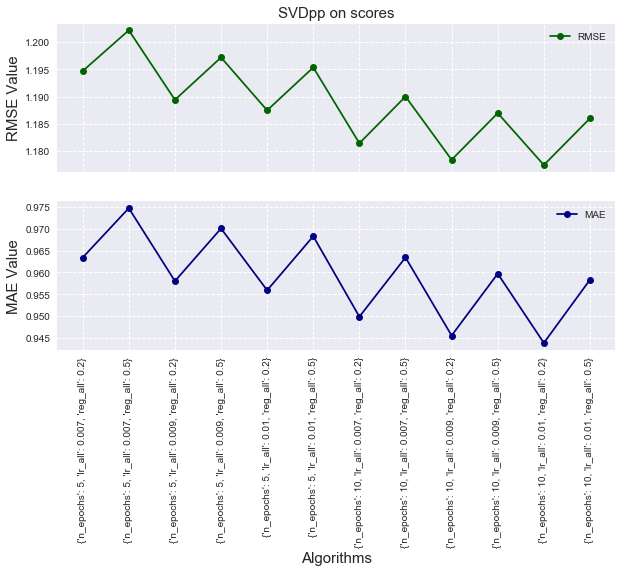

In [186]:
fig, ax = plt.subplots(2,1, figsize=(10,6))
ax[0].set_title('SVDpp on scores', loc='center', fontsize=15)
ax[0].plot([str(x1) for x1 in x], y1, label='RMSE', color='darkgreen', marker='o')
ax[0].set_xticklabels(['','','','','',''])
# ax[0].barh([str(x1) for x1 in x], y1)
# ax[0].set_xlabel('Algorithms', fontsize=15)
ax[0].set_ylabel('RMSE Value', fontsize=15)
ax[0].legend()
ax[0].grid(ls='dashed')

# ax[1].set_title('SVDpp on MAE', loc='center', fontsize=15)
ax[1].plot([str(x1) for x1 in x], y2, label='MAE', color='navy', marker='o')
ax[1].set_xticklabels([str(x1) for x1 in x], rotation=90)
ax[1].set_xlabel('Algorithms', fontsize=15)
ax[1].set_ylabel('MAE Value', fontsize=15)
ax[1].legend()
ax[1].grid(ls='dashed')

plt.savefig('../img/SVDpp_scores.png', dpi=300, transparency=True)
plt.show();


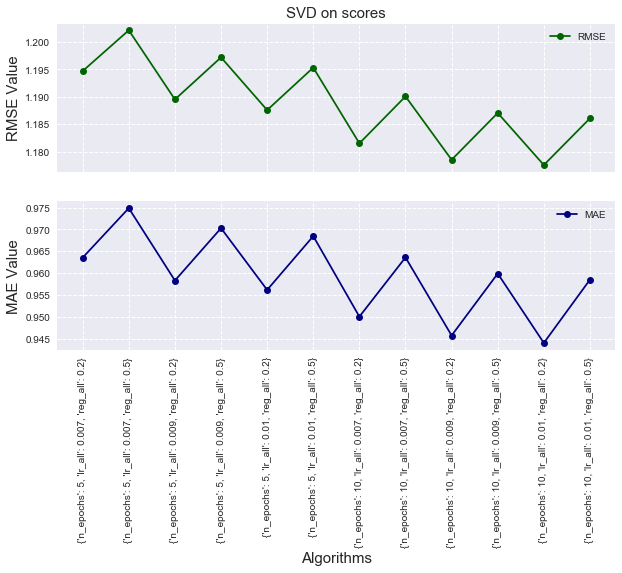

In [187]:
fig, ax = plt.subplots(2,1, figsize=(10,6))
ax[0].set_title('SVD on scores', loc='center', fontsize=15)
ax[0].plot([str(x1) for x1 in x], y3, label='RMSE', color='darkgreen', marker='o')
ax[0].set_xticklabels(['','','','','',''])
# ax[0].barh([str(x1) for x1 in x], y1)
# ax[0].set_xlabel('Algorithms', fontsize=15)
ax[0].set_ylabel('RMSE Value', fontsize=15)
ax[0].legend()
ax[0].grid(ls='dashed')

# ax[1].set_title('SVDpp on MAE', loc='center', fontsize=15)
ax[1].plot([str(x1) for x1 in x], y4, label='MAE', color='navy', marker='o')
ax[1].set_xticklabels([str(x1) for x1 in x], rotation=90)
ax[1].set_xlabel('Algorithms', fontsize=15)
ax[1].set_ylabel('MAE Value', fontsize=15)
ax[1].legend()
ax[1].grid(ls='dashed')

plt.savefig('../img/SVD_scores.png', dpi=300, transparency=True)
plt.show();

## Best model = SVD++
* SVD++ (SVDpp) was marginally better than SVD in terms of RSME score (1.1775 vs 1.1776)
* SVD++ also took 50% longer to compute over SVD (45min vs 30min)
* SVD++ was also the best model from the <a href='http://buzzard.ups.edu/courses/2014spring/420projects/math420-UPS-spring-2014-gower-netflix-SVD.pdf'>$1M netflix competition</a> so it makes sense that it would work well in general

#### Final Hyperparameters
* epoch 10
* learning rate 0.01
* reg_all: 0.2

## Testing Predictions using SVD++

on trainset/testset

In [213]:
start = time.time()

algo=SVDpp(n_epochs=10, lr_all=0.01, reg_all=0.2, random_state=0, verbose=True)
algo.fit(trainset)

end = time.time()
print('this process took {:.2f} seconds'.format(end-start))

 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9


this process took 416.59 seconds


In [214]:
predictions = algo.test(testset)
accuracy.rmse(predictions)

RMSE: 1.1798


1.1798422331791565

In [219]:
uid = 0
iid = 4
algo.predict(uid, iid)

Prediction(uid=0, iid=4, r_ui=None, est=3.6549299517898515, details={'was_impossible': False})

### First ten predictions

In [329]:
predictions[:10]

[Prediction(uid=20662, iid=3130, r_ui=4.0, est=4.055087464396904, details={'was_impossible': False}),
 Prediction(uid=43414, iid=7985, r_ui=4.0, est=2.9781895575634163, details={'was_impossible': False}),
 Prediction(uid=174275, iid=4419, r_ui=5.0, est=3.9836664388041534, details={'was_impossible': False}),
 Prediction(uid=187680, iid=9265, r_ui=5.0, est=3.9158135809179297, details={'was_impossible': False}),
 Prediction(uid=1062, iid=9380, r_ui=4.0, est=4.294048462289611, details={'was_impossible': False}),
 Prediction(uid=9807, iid=5042, r_ui=2.0, est=3.4248082127449866, details={'was_impossible': False}),
 Prediction(uid=52831, iid=559, r_ui=1.0, est=3.778683791648992, details={'was_impossible': False}),
 Prediction(uid=1809, iid=23, r_ui=5.0, est=4.36463509056888, details={'was_impossible': False}),
 Prediction(uid=3768, iid=3371, r_ui=2.0, est=3.9126327911530803, details={'was_impossible': False}),
 Prediction(uid=2656, iid=1935, r_ui=3.0, est=2.7564351959437463, details={'was_imp

In [333]:
AZNV_df.head()

,business_id,name_x,address,city,state,postal_code,latitude,longitude,stars_x,review_count_x,is_open,attributes,categories,hours,review_id,user_id,stars_y,useful,funny,cool,text,date,name_y,review_count_y,yelping_since,friends,fans,average_stars,likes,compliments,elite_years,hotel?,userid,businessid
0,vx4YAA02Qz6khRD1fZ1MFA,Ping Pang Pong,4000 W Flamingo Rd,Las Vegas,NV,89103,36.116901,-115.193512,3.5,1005,1,"{'RestaurantsPriceRange2': '2', 'BusinessAccep...","[Cantonese, Seafood, Dim Sum, Restaurants, Chi...","{'Monday': '10:0-3:0', 'Tuesday': '10:0-3:0', ...",FwiJ7DQ3a9cBwp1OYlP5VA,A0kENtCCoVT3m7T35zb2Vg,2.0,0,0,0,There are so many good reviews of this place o...,2010-04-02 20:37:54,Anastasia,348,2009-02-15 16:45:34,"BBY1Alonk5V0OLgk_G0rNQ, TY7QgNKJEhvo1zCULlT9Rg...",9,3.66,619,38,3,0,0,0
1,glTBzDHv9wNhEsZa4bQrOA,CatHouse Boutique Nightclub,3900 Las Vegas Blvd S,Las Vegas,NV,89119,36.094822,-115.173216,3.0,178,0,"{'OutdoorSeating': 'False', 'BusinessAcceptsCr...","[Restaurants, Nightlife, Lounges, American (Ne...","{'Monday': '17:0-4:0', 'Tuesday': '17:0-4:0', ...",7ynnTyXiuIWHDkktHsdm4Q,A0kENtCCoVT3m7T35zb2Vg,2.0,1,1,0,"Restaurant-only review; based on that, they wo...",2009-02-16 14:53:11,Anastasia,348,2009-02-15 16:45:34,"BBY1Alonk5V0OLgk_G0rNQ, TY7QgNKJEhvo1zCULlT9Rg...",9,3.66,619,38,3,0,0,1
2,8Q6jl7OW8DZzwANggDspcw,Sugar Factory American Brasserie,"Paris Las Vegas Hotel, 3655 Las Vegas Blvd S",Las Vegas,NV,89109,36.112015,-115.172532,3.0,745,0,"{'RestaurantsDelivery': 'False', 'RestaurantsA...","[Brasseries, Bars, Breakfast & Brunch, Food, C...","{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W...",lO_55KRKtw2Rv1ZIHflX2w,A0kENtCCoVT3m7T35zb2Vg,1.0,0,0,0,"Are you allowed to post the phrase ""sh*t show""...",2012-04-26 01:23:24,Anastasia,348,2009-02-15 16:45:34,"BBY1Alonk5V0OLgk_G0rNQ, TY7QgNKJEhvo1zCULlT9Rg...",9,3.66,619,38,3,0,0,2
3,41b2SLmjLcxTGLVRxASiDA,Country Club,3131 Las Vegas Blvd S,Las Vegas,NV,89109,36.126720,-115.163553,4.0,269,0,"{'RestaurantsAttire': 'u'dressy'', 'Restaurant...","[Restaurants, Breakfast & Brunch, Seafood, Ame...","{'Monday': '0:0-0:0', 'Tuesday': '11:30-14:30'...",0WHDB3dNcUsybN4zRJbFzw,A0kENtCCoVT3m7T35zb2Vg,4.0,0,0,0,Our party of six enjoyed the Sunday jazz brunc...,2011-04-27 00:35:55,Anastasia,348,2009-02-15 16:45:34,"BBY1Alonk5V0OLgk_G0rNQ, TY7QgNKJEhvo1zCULlT9Rg...",9,3.66,619,38,3,0,0,3
4,Ehy00JWQixgoXzisVKhvag,Cucina by Wolfgang Puck,3720 S Las Vegas Blvd,Las Vegas,NV,89158,36.107677,-115.175062,4.0,921,1,"{'RestaurantsDelivery': 'False', 'RestaurantsP...","[Restaurants, Italian, Pizza]","{'Monday': '11:30-22:0', 'Tuesday': '11:30-22:...",tL3FZuCRK4q4d_bAF-VDOQ,A0kENtCCoVT3m7T35zb2Vg,5.0,0,0,0,This was the best surprise of our recent trip ...,2012-04-26 01:11:46,Anastasia,348,2009-02-15 16:45:34,"BBY1Alonk5V0OLgk_G0rNQ, TY7QgNKJEhvo1zCULlT9Rg...",9,3.66,619,38,3,0,0,4


In [343]:
summary_df = AZNV_df.groupby(['state', 'city', 'name_x', 'business_id', 'stars_x'])['review_id'].count().sort_values(axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last').to_frame()
summary_df = summary_df.reset_index()
summary_df.head(10)

,state,city,name_x,business_id,stars_x,review_id
0,NV,Las Vegas,Mon Ami Gabi,4JNXUYY8wbaaDmk3BPzlWw,4.0,5362
1,NV,Las Vegas,Bacchanal Buffet,RESDUcs7fIiihp38-d6_6g,4.0,5162
2,NV,Las Vegas,Wicked Spoon,K7lWdNUhCbcnEvI0NhGewg,3.5,4371
3,NV,Las Vegas,Earl of Sandwich,DkYS3arLOhA8si5uUEmHOw,4.5,3735
4,NV,Las Vegas,Hash House A Go Go,f4x1YBxkLrZg652xt2KR5g,4.0,3330
5,NV,Las Vegas,Gordon Ramsay BurGR,cYwJA2A6I12KNkm2rtXd5g,4.0,3159
6,NV,Las Vegas,Secret Pizza,iCQpiavjjPzJ5_3gPD5Ebg,4.0,3076
7,NV,Las Vegas,Lotus of Siam,KskYqH1Bi7Z_61pH6Om8pg,4.0,2771
8,NV,Las Vegas,The Buffet at Bellagio,ujHiaprwCQ5ewziu0Vi9rw,3.5,2762
9,NV,Las Vegas,Serendipity 3,eoHdUeQDNgQ6WYEnP2aiRw,3.0,2696


In [345]:
city_df = summary_df.groupby(['state', 'city'])['review_id'].sum().sort_values(axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last').to_frame()
city_df = city_df.reset_index()
city_df.head(10)

,state,city,review_id
0,NV,Las Vegas,807921
1,AZ,Phoenix,324853
2,AZ,Scottsdale,172281
3,AZ,Tempe,89927
4,NV,Henderson,85176
5,AZ,Chandler,68830
6,AZ,Mesa,66943
7,AZ,Gilbert,53971
8,AZ,Glendale,42317
9,AZ,Peoria,22914


# Scoring the Predictions

Finding the Hit-Rate or Accuracy, how many times did we correctly predict the rating of the user?

https://towardsdatascience.com/evaluating-a-real-life-recommender-system-error-based-and-ranking-based-84708e3285b

In [114]:
start = time.time()

score_df = AZNV_df[['business_id', 'name_x', 'city', 'state', 'stars_x', 'stars_y', 'date']]

# user_labels and businesslabels are from code in the beginning to create the df for spark ALS
# user_labels, user_uniques = pd.factorize(AZNV_df['user_id'])
# business_labels, business_uniques = pd.factorize(AZNV_df['business_id'])
score_df['userid'] = user_labels
score_df['restaurantid'] = business_labels
score_df['pred_rating'] = score_df.apply(lambda x: algo.predict(x.userid, x.restaurantid)[3], axis=1)

end = time.time()
os.system('say "the scoring has finished"');

print(score_df.shape)
score_df.head()

0

(1818490, 10)


,business_id,name_x,city,state,stars_x,stars_y,date,userid,restaurantid,pred_rating
0,vx4YAA02Qz6khRD1fZ1MFA,Ping Pang Pong,Las Vegas,NV,3.5,2.0,2010-04-02 20:37:54,0,0,3.633105
1,glTBzDHv9wNhEsZa4bQrOA,CatHouse Boutique Nightclub,Las Vegas,NV,3.0,2.0,2009-02-16 14:53:11,0,1,3.502029
2,8Q6jl7OW8DZzwANggDspcw,Sugar Factory American Brasserie,Las Vegas,NV,3.0,1.0,2012-04-26 01:23:24,0,2,3.038446
3,41b2SLmjLcxTGLVRxASiDA,Country Club,Las Vegas,NV,4.0,4.0,2011-04-27 00:35:55,0,3,3.963400
4,Ehy00JWQixgoXzisVKhvag,Cucina by Wolfgang Puck,Las Vegas,NV,4.0,5.0,2012-04-26 01:11:46,0,4,3.909215


In [132]:
score_df['accuracy'] = score_df.apply(lambda x: 1 if round(abs(x.stars_y-x.pred_rating))==0 else 0, axis=1)
print('the accuracy of the model pred: {:2f}'.format(sum(score_df.accuracy)/len(score_df)))

the accuracy of the model pred: 0.281565


### My model had an accuracy of 28%, this better than random guessing of 1/5 or 20%

### How does it compare to guessing the mean or median?

In [123]:
np.mean(score_df.stars_y)

3.789515477126627

In [127]:
score_df['mean_accuracy'] = score_df.apply(lambda x: 1 if round(abs(3.789515477126627-x.pred_rating))==0 else 0, axis=1)
print('evaluating prediction ratings against the mean of actual ratings: {:2f}'.format(sum(score_df.mean_accuracy)/len(score_df)))

evaluating prediction ratings against the mean of actual ratings: 0.806832


In [128]:
np.median(score_df.stars_y)

4.0

In [129]:
score_df['median_accuracy'] = score_df.apply(lambda x: 1 if round(abs(4.0-x.pred_rating))==0 else 0, axis=1)
print('evaluating prediction ratings against the mean of actual ratings: {:2f}'.format(sum(score_df.median_accuracy)/len(score_df)))

evaluating prediction ratings against the mean of actual ratings: 0.789338


### Guessing the mean or median turns out to be more accurate.
* Mean - 80.68% accuracy
* Median - 78.93% accuracy

### Let's see how far off our predictions are from by 0.5 and 1 star from the actual

The idea behind this is many reviews may want to rate a place 3.5 stars but may end up rating a 3.0 or 4.0 since the Yelp dataset only allow ratings in whole numbers.

Another concept is that one reviewer may rate a place 3 stars one-day and 4 stars the next, so there may also some qualitative fluxuations in accessing a restaurant

In [134]:
score_df['accuracy_by_half_star'] = score_df.apply(lambda x: 1 if abs(x.stars_y-x.pred_rating)<=0.5 else 0, axis=1)
print('accuracy +/-0.5 stars of model pred: {:2f}'.format(sum(score_df.accuracy_by_half_star)/len(score_df)))

accuracy +/-0.5 stars of model pred: 0.281565


### cannot round by half-stars easily, let's look at whole stars

In [137]:
score_df['accuracy_by_one_star'] = score_df.apply(lambda x: 1 if round(abs(x.stars_y-x.pred_rating))<=1 else 0, axis=1)
print('accuracy +/-1 stars of model pred: {:2f}'.format(sum(score_df.accuracy_by_one_star)/len(score_df)))

accuracy +/-1 stars of model pred: 0.816542


### Model Accuracy:

Exact Match    :  <b>28.16%</b>
<br>
Match by 1-star:  <b>81.65%</b>

# Recommendations

This part is tied to the development of a web demo

## Prediction

### Creating Recommendation for new users (cold start)

* have new user input 5-star ratings into the recommender
* recommender will provide top results by city, cuisine similiarity, etc

Find predictions for a user

* step 1: input: 5 ratings from new user
* step 2: retrain model
* step 3: output: provide recommendations

### First, need to create dataframes for performing predictions

In [19]:
# this is the dataframe for the predictive model

print(pandas_df.shape)
pandas_df.head()

(1818490, 3)


,userid,restaurantid,rating
0,0,0,2.0
1,0,1,2.0
2,0,2,1.0
3,0,3,4.0
4,0,4,5.0


In [148]:
# dataframe to look up business name from once we have the predicted restaurant recommendation

ref_df = AZNV_df[['business_id', 'name_x', 'stars_x', 'review_count_x', 'city', 'state']]
# ref_df['p_userid'] = pandas_df['userid'] 
ref_df['p_restaurantid'] = pandas_df['restaurantid']
# ref_df['p_rating'] = pandas_df['rating']
ref_df = ref_df.drop_duplicates()
print(ref_df.shape)
ref_df.head()

(14797, 7)


,business_id,name_x,stars_x,review_count_x,city,state,p_restaurantid
0,vx4YAA02Qz6khRD1fZ1MFA,Ping Pang Pong,3.5,1005,Las Vegas,NV,0
1,glTBzDHv9wNhEsZa4bQrOA,CatHouse Boutique Nightclub,3.0,178,Las Vegas,NV,1
2,8Q6jl7OW8DZzwANggDspcw,Sugar Factory American Brasserie,3.0,745,Las Vegas,NV,2
3,41b2SLmjLcxTGLVRxASiDA,Country Club,4.0,269,Las Vegas,NV,3
4,Ehy00JWQixgoXzisVKhvag,Cucina by Wolfgang Puck,4.0,921,Las Vegas,NV,4


### Pickle the dfs

In [149]:
ref_df.to_pickle('../data/ref_df.p')

### Code to load dataframes faster when booting up next

In [150]:
pandas_df = pd.read_pickle('../data/model_pandas_df.p')
ref_df = pd.read_pickle('../data/ref_df.p')
print('ref_df: ', ref_df.shape)
print('pandas_df: ', pandas_df.shape)

ref_df:  (14797, 7)
pandas_df:  (1818490, 3)


### Get list of restaurants for user to choose from

Filtered for restaurants in Las Vegas, NV with overall review > 4.0

In [160]:
r_df = ref_df[ref_df['city']=='Las Vegas']
r_df = r_df[r_df['state']=='NV']
r_df = r_df[r_df['stars_x']>=4.0]
r_df = r_df.sort_values(by=['review_count_x'], ascending=False)
r_df.head()

,business_id,name_x,stars_x,review_count_x,city,state,p_restaurantid
67,4JNXUYY8wbaaDmk3BPzlWw,Mon Ami Gabi,4.0,8348,Las Vegas,NV,61
70,RESDUcs7fIiihp38-d6_6g,Bacchanal Buffet,4.0,8339,Las Vegas,NV,64
34,f4x1YBxkLrZg652xt2KR5g,Hash House A Go Go,4.0,5763,Las Vegas,NV,34
17,cYwJA2A6I12KNkm2rtXd5g,Gordon Ramsay BurGR,4.0,5484,Las Vegas,NV,17
23,DkYS3arLOhA8si5uUEmHOw,Earl of Sandwich,4.5,5075,Las Vegas,NV,23


In [236]:
rid_list = list(r_df.head(12)['p_restaurantid'])
rid_list

[61, 64, 34, 17, 23, 86, 29, 87, 767, 4178, 1524, 45]

In [234]:
rname_list = list(r_df.head(12)['name_x'])
rname_list

['Mon Ami Gabi',
 'Bacchanal Buffet',
 'Hash House A Go Go',
 'Gordon Ramsay BurGR',
 'Earl of Sandwich',
 'Secret Pizza',
 'Lotus of Siam',
 'Bouchon',
 'Yardbird Southern Table & Bar',
 'Gordon Ramsay Steak',
 'Gangnam Asian BBQ Dining',
 'Bachi Burger']

### Enter every permutation of the new users ratings into the dataframe

* this will allow us to provide score predictions on any restaurant in the model

* Then evalulate what is the best restaurant to recommend

#### making a list of lists of all of the possibilities

In [238]:
# there are 12 restaraunts choose 5, 792 combinations

# from https://www.geeksforgeeks.org/permutation-and-combination-in-python/
# A Python program to print all combinations of given length 
from itertools import combinations 

# Get all combinations of [1, 2, 3] and length 2 
comb = list(combinations(rid_list, 5)) #comb is the list of all combinations (12 choose 5)

# Print the obtained combinations 
# for i in list(comb): 
#     print (i) 

print(comb[:5])
len(comb)

[(61, 64, 34, 17, 23), (61, 64, 34, 17, 86), (61, 64, 34, 17, 29), (61, 64, 34, 17, 87), (61, 64, 34, 17, 767)]


792

In [252]:
# function to add user prediction

def add_user_rating(df, userid, restaurant_list, rating_list):
    for i, restaurant in enumerate(restaurant_list):
        df = df.append({'userid':userid, 'restaurantid':restaurant, 'rating':rating_list[i]}, ignore_index=True)
    return df

In [253]:
uid_count=300000 #userid counter, all inputted users with will a userid > 300000
rating_lst = [5, 5, 5, 5, 5] #every picked restaurant gets a 5.

test_df = pandas_df.copy()
for r_list in comb:
    uid_count+=1
    test_df = add_user_rating(test_df, uid_count, list(r_list), rating_lst)

print(test_df.shape)
test_df.tail(10)

(1822450, 3)


,userid,restaurantid,rating
1822440,300791,29,5.0
1822441,300791,767,5.0
1822442,300791,4178,5.0
1822443,300791,1524,5.0
1822444,300791,45,5.0
1822445,300792,87,5.0
1822446,300792,767,5.0
1822447,300792,4178,5.0
1822448,300792,1524,5.0
1822449,300792,45,5.0


### Train the model with the new user's ratings

In [254]:
# Set Rating Scale
reader = Reader(rating_scale=(1, 5))

# Load data with rating scale
data = Dataset.load_from_df(test_df, reader)

# train on full dataset
# https://surprise.readthedocs.io/en/stable/getting_started.html
trainset = data.build_full_trainset()

start = time.time()

algo=SVDpp(n_epochs=10, lr_all=0.01, reg_all=0.2, random_state=0, verbose=False)
algo.fit(trainset)

end = time.time()
print('this process took {:.2f} seconds'.format(end-start))

os.system('say "the model has finished"');

this process took 731.66 seconds


In [255]:
uid=300001
iid=64
algo.predict(uid, iid)

Prediction(uid=300001, iid=64, r_ui=None, est=5, details={'was_impossible': False})

## Building the Prediction DF

In [256]:
# algo.predict(uid, iid)

start = time.time()

restaurant_list = test_df['restaurantid'].unique()
pred_list = []

for uid in range(300001, 300792+1): #loop through every added user
    for iid in restaurant_list: #loop through every restaurant in our dataset
        pred_rating = algo.predict(uid, iid)[3]
        pred_list.append(pred_rating)

#method to duplicate lists by n times
def duplicate(testList, n):
    new_list = [] 
    for i in range(n):
        new_list.extend(testList)
    return new_list
        
# create list of userids to add to a prediction df
userid_list = [[i]*len(restaurant_list) for i in range(300001, 300792+1)]
userid_list = [item for sublist in userid_list for item in sublist]

# create list of restaurantid to add to a prediction df
restaurant_list = duplicate(restaurant_list, 792)

#create prediction DF
pred_df = pd.DataFrame()
pred_df['uid'] = userid_list
pred_df['restaurantid'] = restaurant_list
pred_df['pred_rating'] = pred_list

end = time.time()

print('this process took {:.2f} seconds'.format(end-start))
os.system('say "the prediction dataframe has finished compiling"');

print(pred_df.shape)
pred_df.head()

this process took 301.22 seconds


0

(11719224, 3)


,uid,restaurantid,pred_rating
0,300001,0,4.141554
1,300001,1,3.849536
2,300001,2,3.510306
3,300001,3,4.455940
4,300001,4,4.344842


### Remove the 12 restaurants from the list of predictions

In [266]:
for rid in rid_list:
    pred_df = pred_df[pred_df['restaurantid']!=rid]

pred_df.shape

(11709720, 3)

### Pickle this result

In [265]:
pred_df.to_pickle('../data/pred_df.p')

### load pickle

In [ ]:
pred_df = pd.read_pickle('../data/pred_df.p')

## Get top 3 recommendation for each user (Vegas / Phoenix)

In [267]:
# sort df
pred_df = pred_df.sort_values(by=['pred_rating'], ascending=False)

In [268]:
pred_df2 = pd.merge(pred_df, ref_df, how='inner', left_on='restaurantid', right_on='p_restaurantid')

print(pred_df.shape)
pred_df2.head()

(11709720, 3)


,uid,restaurantid,pred_rating,business_id,name_x,stars_x,review_count_x,city,state,p_restaurantid
0,300199,11103,5.0,VEknvhHwiTTSCR1ALRN0GA,Grocery Station,5.0,42,Scottsdale,AZ,11103
1,300098,11103,5.0,VEknvhHwiTTSCR1ALRN0GA,Grocery Station,5.0,42,Scottsdale,AZ,11103
2,300097,11103,5.0,VEknvhHwiTTSCR1ALRN0GA,Grocery Station,5.0,42,Scottsdale,AZ,11103
3,300142,11103,5.0,VEknvhHwiTTSCR1ALRN0GA,Grocery Station,5.0,42,Scottsdale,AZ,11103
4,300061,11103,5.0,VEknvhHwiTTSCR1ALRN0GA,Grocery Station,5.0,42,Scottsdale,AZ,11103


### Removing Review count < 300

want to recommend more established restaurants

In [269]:
pred_df2 = pred_df2[pred_df2['review_count_x']>300]
pred_df2.head(2)

,uid,restaurantid,pred_rating,business_id,name_x,stars_x,review_count_x,city,state,p_restaurantid
15840,300013,7845,5.0,52yWGkwnrQXIjvuMjYxsiA,Not Your Typical Deli,5.0,402,Gilbert,AZ,7845
15841,300017,7845,5.0,52yWGkwnrQXIjvuMjYxsiA,Not Your Typical Deli,5.0,402,Gilbert,AZ,7845


### Arizona DF

returns a dataframe with the top 5 recommendations for each user in Phoenix

In [270]:
start = time.time()

az_pred_df = pred_df2[pred_df2['state']=='AZ']
az_pred_df = az_pred_df[az_pred_df['city']=='Phoenix']

top_phoenix_pred_df = pd.DataFrame()

for uid in range(300001, 300792+1):
    temp_df = az_pred_df[az_pred_df['uid']==uid].head(5)
    top_phoenix_pred_df = top_phoenix_pred_df.append(temp_df, ignore_index=True)

end = time.time()

print('the process was complete in {:.2f} seconds'.format(end-start))
os.system('say "the dataframe is complete!!"');

top_phoenix_pred_df.head(10)

the process was complete in 4.03 seconds


0

,uid,restaurantid,pred_rating,business_id,name_x,stars_x,review_count_x,city,state,p_restaurantid
0,300001,3041,4.935928,Cp-clhAJs3NJRwXpXk_saw,The Whining Pig-Phoenix,4.5,378,Phoenix,AZ,3041
1,300001,3284,4.951550,Xg5qEQiB-7L6kGJ5F4K3bQ,Little Miss BBQ,5.0,1936,Phoenix,AZ,3284
2,300001,7584,4.943484,fSBhe0A6Dfa8JCYccfpMog,The Bagel Man,4.5,518,Phoenix,AZ,7584
3,300001,2676,4.923398,jIzygnVmajEXYmfsBNY_Gw,Most Wanted Taco Shop,4.5,576,Phoenix,AZ,2676
4,300001,4921,4.911963,NeDqVEiin0q-FxCvOKiERw,My Slice of the Pie Pizzeria,4.5,318,Phoenix,AZ,4921
5,300002,3041,4.977238,Cp-clhAJs3NJRwXpXk_saw,The Whining Pig-Phoenix,4.5,378,Phoenix,AZ,3041
6,300002,3284,4.964212,Xg5qEQiB-7L6kGJ5F4K3bQ,Little Miss BBQ,5.0,1936,Phoenix,AZ,3284
7,300002,7584,4.951642,fSBhe0A6Dfa8JCYccfpMog,The Bagel Man,4.5,518,Phoenix,AZ,7584
8,300002,2676,4.921192,jIzygnVmajEXYmfsBNY_Gw,Most Wanted Taco Shop,4.5,576,Phoenix,AZ,2676
9,300002,4921,4.908785,NeDqVEiin0q-FxCvOKiERw,My Slice of the Pie Pizzeria,4.5,318,Phoenix,AZ,4921


### Vegas DF

In [271]:
start = time.time()

az_pred_df = pred_df2[pred_df2['state']=='NV']
az_pred_df = az_pred_df[az_pred_df['city']=='Las Vegas']

top_vegas_pred_df = pd.DataFrame()

for uid in range(300001, 300792+1):
    temp_df = az_pred_df[az_pred_df['uid']==uid].head(5)
    top_vegas_pred_df = top_vegas_pred_df.append(temp_df, ignore_index=True)

end = time.time()

print('the process was complete in {:.2f} seconds'.format(end-start))
os.system('say "the dataframe is complete!!"');

top_vegas_pred_df.head(10)

the process was complete in 4.16 seconds


0

,uid,restaurantid,pred_rating,business_id,name_x,stars_x,review_count_x,city,state,p_restaurantid
0,300001,168,5.000000,IhNASEZ3XnBHmuuVnWdIwA,Brew Tea Bar,5.0,1506,Las Vegas,NV,168
1,300001,1054,5.000000,O7UMzd3i-Zk8dMeyY9ZwoA,Art of Flavors,5.0,350,Las Vegas,NV,1054
2,300001,1580,5.000000,8fFTJBh0RB2EKG53ibiBKw,Zenaida's Cafe,5.0,374,Las Vegas,NV,1580
3,300001,106,4.989649,L1-1P3acJc4gEFvWwjXcNQ,Meráki Greek Grill,4.5,553,Las Vegas,NV,106
4,300001,238,4.965342,wWuGa3OOQJro_XGe-GKBXA,Kabuto,4.5,601,Las Vegas,NV,238
5,300002,168,5.000000,IhNASEZ3XnBHmuuVnWdIwA,Brew Tea Bar,5.0,1506,Las Vegas,NV,168
6,300002,1054,5.000000,O7UMzd3i-Zk8dMeyY9ZwoA,Art of Flavors,5.0,350,Las Vegas,NV,1054
7,300002,1580,5.000000,8fFTJBh0RB2EKG53ibiBKw,Zenaida's Cafe,5.0,374,Las Vegas,NV,1580
8,300002,106,5.000000,L1-1P3acJc4gEFvWwjXcNQ,Meráki Greek Grill,4.5,553,Las Vegas,NV,106
9,300002,238,4.995443,wWuGa3OOQJro_XGe-GKBXA,Kabuto,4.5,601,Las Vegas,NV,238


## Let's recommend!!

In [263]:
rid_list

[61, 64, 34, 17, 23, 86, 29, 87, 767, 4178, 1524, 45]

In [ ]:
## enumerate the rid_list and append those numbers to df, then we can look up the df index and provide best recommendation

In [ ]:
# https://www.yelp.com/biz/IhNASEZ3XnBHmuuVnWdIwA

In [77]:
test = pd.merge(pred_df, ref_df, how='inner', left_on='restaurantid', right_on='p_restaurantid')
# test=test.drop_duplicates() 
test = test.sort_values(by=['pred_rating'], ascending=False)

In [78]:
print(test.shape)
test.head()

(14797, 8)


,uid,restaurantid,pred_rating,business_id,name_x,city,state,p_restaurantid
168,300000,168,4.777206,IhNASEZ3XnBHmuuVnWdIwA,Brew Tea Bar,Las Vegas,NV,168
4901,300000,4901,4.742406,SSCH4Z2gw-hh2KZy7aH4qw,Worth Takeaway,Mesa,AZ,4901
5375,300000,5375,4.722760,kR4NBNFf5SLpeAtZ-uPoPg,That's Amore Gelato,Scottsdale,AZ,5375
7055,300000,7055,4.699447,PhMfnMldVKXo7HqHw6DSrg,DaYung's Tea,Tempe,AZ,7055
4746,300000,4746,4.698295,1qkKfqhO8z2XMzLLDFE96Q,Kodo Sushi Sake,Scottsdale,AZ,4746


In [63]:
vegas = test[test['city']=='Las Vegas']
vegas.head(10)

,uid,restaurantid,pred_rating,business_id,name_x,city,state,p_restaurantid
135976,300000,168,4.777206,IhNASEZ3XnBHmuuVnWdIwA,Brew Tea Bar,Las Vegas,NV,168
97215,300000,106,4.678763,L1-1P3acJc4gEFvWwjXcNQ,Meráki Greek Grill,Las Vegas,NV,106
697660,300000,2257,4.678170,tMdgY7Ou4k3bYZZulJCiuQ,Bronze Cafe at The Center,Las Vegas,NV,2257
921425,300000,3629,4.675145,G4hjhtA_wQ-tSOGpgGlDjw,Bajamar Seafood & Tacos,Las Vegas,NV,3629
403875,300000,1054,4.675103,O7UMzd3i-Zk8dMeyY9ZwoA,Art of Flavors,Las Vegas,NV,1054
551563,300000,1580,4.669150,8fFTJBh0RB2EKG53ibiBKw,Zenaida's Cafe,Las Vegas,NV,1580
521978,300000,1473,4.658875,ybHlmdUHLPKfv85bRK4Wtw,Grouchy John's Coffee,Las Vegas,NV,1473
99552,300000,108,4.656025,2B46bRpDh49eDyjXGhL_ZQ,La Maison de Maggie,Las Vegas,NV,108
550311,300000,1572,4.647656,TrGBHqHVzJM5tk2C1D1ctQ,The Sandwich Spot,Las Vegas,NV,1572
793452,300000,2910,4.626099,cePE3rCuUOVSCCAHSjWxoQ,Karved,Las Vegas,NV,2910


In [ ]:
vegas = test[test['city']=='Las Vegas']
vegas.head(10)

In [64]:
phoenix = test[test['city']=='Phoenix']
phoenix.head(10)

,uid,restaurantid,pred_rating,business_id,name_x,city,state,p_restaurantid
857863,300000,3284,4.662891,Xg5qEQiB-7L6kGJ5F4K3bQ,Little Miss BBQ,Phoenix,AZ,3284
756155,300000,2676,4.631993,jIzygnVmajEXYmfsBNY_Gw,Most Wanted Taco Shop,Phoenix,AZ,2676
1460832,300000,7584,4.614427,fSBhe0A6Dfa8JCYccfpMog,The Bagel Man,Phoenix,AZ,7584
1692440,300000,10861,4.592698,WpzRURptZ2FIxBmJMl4MXA,KamanaWana Hawaiian Treats,Phoenix,AZ,10861
813434,300000,3041,4.586555,Cp-clhAJs3NJRwXpXk_saw,The Whining Pig-Phoenix,Phoenix,AZ,3041
222603,300000,472,4.584540,xdD3EXvF_p9WUiwwKpol_w,Ten Handcrafted American Fare & Spirits,Phoenix,AZ,472
1193480,300000,5406,4.576988,aXRrMXXoAN7lawHICgmsxw,The Dressing Room,Phoenix,AZ,5406
1118336,300000,4964,4.570955,-kIscN8I29eXMPkvyyxmRQ,Zookz Sandwiches,Phoenix,AZ,4964
817101,300000,3056,4.541024,cTZmf7B-4yciMc1WKiCVOA,Welcome Diner,Phoenix,AZ,3056
1668899,300000,10368,4.530393,mss-LiOfL1vtoNo3WoEoJw,Kiss Pollos Estilo Sinaloa,Phoenix,AZ,10368


In [87]:
restaurant_lst_id = [64, 53, 23, 34, 17]

In [89]:

for r in restaurant_lst_id:
    test[test['p_restaurantid']==r]['pred_rating']

64    4.078209
Name: pred_rating, dtype: float64

53    3.83922
Name: pred_rating, dtype: float64

23    4.31406
Name: pred_rating, dtype: float64

34    3.943505
Name: pred_rating, dtype: float64

17    4.025051
Name: pred_rating, dtype: float64

In [149]:
"""
This module illustrates how to retrieve the top-10 items with highest rating
prediction. We first train an SVD algorithm on the MovieLens dataset, and then
predict all the ratings for the pairs (user, item) that are not in the training
set. We then retrieve the top-10 prediction for each user.
"""

from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
from collections import defaultdict

from surprise import SVD
from surprise import Dataset


def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.
    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.
    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


# First train an SVD algorithm on the movielens dataset.
# data = Dataset.load_builtin('ml-100k')
# trainset = data.build_full_trainset()
# algo = SVD()
# algo.fit(trainset)

# Than predict ratings for all pairs (u, i) that are NOT in the training set.
# testset = trainset.build_anti_testset()
# predictions = algo.test(testset)

top_n = get_top_n(predictions, n=10)

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    if(uid==300000):
        print(uid, [iid for (iid, _) in user_ratings])

'\nThis module illustrates how to retrieve the top-10 items with highest rating\nprediction. We first train an SVD algorithm on the MovieLens dataset, and then\npredict all the ratings for the pairs (user, item) that are not in the training\nset. We then retrieve the top-10 prediction for each user.\n'

300000 [64]


In [150]:
ref_df[ref_df['predict_restaurantid']==64]

,business_id,name_x,city,state,predict_userid,predict_restaurantid,predict_rating
70,RESDUcs7fIiihp38-d6_6g,Bacchanal Buffet,Las Vegas,NV,6,64,4.0
125,RESDUcs7fIiihp38-d6_6g,Bacchanal Buffet,Las Vegas,NV,12,64,3.0
137,RESDUcs7fIiihp38-d6_6g,Bacchanal Buffet,Las Vegas,NV,14,64,3.0
179,RESDUcs7fIiihp38-d6_6g,Bacchanal Buffet,Las Vegas,NV,20,64,4.0
1227,RESDUcs7fIiihp38-d6_6g,Bacchanal Buffet,Las Vegas,NV,48,64,1.0
1238,RESDUcs7fIiihp38-d6_6g,Bacchanal Buffet,Las Vegas,NV,49,64,4.0
1683,RESDUcs7fIiihp38-d6_6g,Bacchanal Buffet,Las Vegas,NV,60,64,4.0
3529,RESDUcs7fIiihp38-d6_6g,Bacchanal Buffet,Las Vegas,NV,95,64,4.0
5029,RESDUcs7fIiihp38-d6_6g,Bacchanal Buffet,Las Vegas,NV,120,64,5.0
5520,RESDUcs7fIiihp38-d6_6g,Bacchanal Buffet,Las Vegas,NV,135,64,1.0


In [144]:
# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    if(uid==300000):
        print(uid, [iid for (iid, _) in user_ratings])

300000 [64]


In [88]:
prediction_df[prediction_df['predict_restaurantid']==150395]

,business_id,name_x,address,city,state,postal_code,latitude,longitude,stars_x,review_count_x,is_open,attributes,categories,hours,review_id,user_id,stars_y,useful,funny,cool,text,date,name_y,review_count_y,yelping_since,friends,fans,average_stars,likes,compliments,elite_years,hotel?,predict_userid,predict_restaurantid,predict_rating
1822913,UBQRhqRMW4Sk7kSZvZ1iAQ,Essence Bakery Café,825 W University Dr,Tempe,AZ,85281,33.421657,-111.951170,4.0,442,0,"{'Ambience': '{'romantic': False, 'intimate': ...","[Restaurants, Breakfast & Brunch, Specialty Fo...","{'Tuesday': '7:0-15:0', 'Wednesday': '7:0-15:0...",M7SIyhrZ1PR7U9PPqRrRHA,UKMFnJq_dHUTEqbBU3Bz9A,3.0,2,0,0,To use a yelper term to sum this place up I wa...,2012-06-07 20:30:33,Janet,6,2012-04-18 21:27:18,None,0,2.86,6,0,1,0,150395,3323,3.0
1822914,LwQB9H3jZ9wTk24Lr-AnZQ,Spago by Wolfgang Puck,"The Forum Shops At Caesars, 3500 Las Vegas Blv...",Las Vegas,NV,89109,36.118831,-115.175638,4.0,1070,0,"{'RestaurantsPriceRange2': '3', 'RestaurantsRe...","[American (Traditional), Restaurants, American...","{'Monday': '11:30-23:0', 'Tuesday': '11:30-23:...",3UTx8fn9tiRskqwUM72kAQ,UKMFnJq_dHUTEqbBU3Bz9A,5.0,0,0,0,I had the chopped veggie salad. The veggies w...,2012-05-28 06:42:30,Janet,6,2012-04-18 21:27:18,None,0,2.86,6,0,1,0,150395,961,5.0
1822915,0P46EQN6wGc52nONZX0kgQ,Amalfi Ristorante Italiano,"4991 S Alma School Rd, Ste 12",Chandler,AZ,85248,33.233319,-111.858322,3.5,152,1,"{'BusinessParking': '{'garage': False, 'street...","[Restaurants, Pizza, Italian]","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",NUIr94PgnSET_qgVwP2PkQ,UKMFnJq_dHUTEqbBU3Bz9A,2.0,1,1,0,My family and I went here on father's day to c...,2012-06-17 23:47:35,Janet,6,2012-04-18 21:27:18,None,0,2.86,6,0,1,0,150395,7909,2.0
1822916,IbDCaYwFi-e-nhEmH-FYPA,Kona Grill,"Chandler Fashion Center, 3111 W Chandler Blvd",Chandler,AZ,85226,33.301586,-111.898593,3.5,387,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","[American (New), Sushi Bars, American (Traditi...","{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'...",fqeAehiwNjiGvsLIpWM5xA,UKMFnJq_dHUTEqbBU3Bz9A,5.0,0,0,0,"Sat outside, watched the European Cup Soccer m...",2012-07-02 21:09:23,Janet,6,2012-04-18 21:27:18,None,0,2.86,6,0,1,0,150395,4665,5.0


In [119]:
def recommend_restaurants(predictions, userID, df, original_ratings, num_recommendations):
    
    # Get and sort the user's predictions
    user_row_number = userID - 1 # User ID starts at 1, not 0
    sorted_user_predictions = preds.iloc[user_row_number].sort_values(ascending=False) # User ID starts at 1
    
    # Get the user's data and merge in the movie information.
    user_data = original_ratings[original_ratings.user_id == (userID)]
    user_full = (user_data.merge(df, how = 'left', left_on = 'business_id', right_on = 'business_id').
                     sort_values(['rating'], ascending=False)
                 )
    
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = (df[~df['business_id'].isin(user_full['business_id'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
               left_on = 'business_id',
               right_on = 'business_id').
         rename(columns = {user_row_number: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations, :-1]
                      )

    return user_full, recommendations

In [123]:
# -*- coding: utf-8 -*-
"""
Created on Mon Dec 25 14:48:41 2017
@author: rahmeen
"""

import pandas as pd
import numpy as np
userCol = ['user_id', 'age', 'gender', 'occupation', 'zip_code']
users = pd.read_csv('Data/ml-100k/u.user', sep='|', names=userCol, encoding='latin-1')
ratingsCol = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('Data/ml-100k/u.data', sep='\t', names=ratingsCol, encoding='latin-1')



movieCol = ['movie_id', 'title','release', 'date_of_release', 'url', 'unknown', 'Action', 'Adventure','Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy','Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western' ]
movies = pd.read_csv('Data/ml-100k/u.item', sep='|',names=movieCol, encoding='latin-1')


# userDF = pd.DataFrame(users,columns=userCol)
# movieDF = pd.DataFrame(movies, columns=movieCol)
# ratingDF = pd.DataFrame(ratings, columns=ratingsCol)

userDF = pd.DataFrame(users,columns=userCol)
movieDF = pd.DataFrame(movies, columns=movieCol)
ratingDF = pd.DataFrame(ratings, columns=ratingsCol)

ratingsAll = ratingDF.pivot(index = 'user_id', columns ='movie_id', values = 'rating').fillna(0)
ratingsAll.head()
'''
userDF.head()
movieDF.head()
ratingDF.head()
'''

#Normalisation as a prestep for svd

r = ratingsAll.as_matrix()
ratingMean = np.mean(r, axis = 1)
rDemeaned = r - ratingMean.reshape(-1, 1)

from scipy.sparse.linalg import svds
U, sigma, Vt = svds(rDemeaned, k = 50)
sigma = np.diag(sigma)

all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + ratingMean.reshape(-1, 1)
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = ratingsAll.columns)

def recommend_movies(predictions_df, userID, movies_df, original_ratings_df, num_recommendations=5):
    
    # Get and sort the user's predictions
    user_row_number = userID - 1 # UserID starts at 1, not 0
    sorted_user_predictions = predictions_df.iloc[user_row_number].sort_values(ascending=False)
    
    # Get the user's data and merge in the movie information.
    user_data = original_ratings_df[original_ratings_df.user_id == (userID)]
    user_full = (user_data.merge(movies_df, how = 'left', left_on = 'movie_id', right_on = 'movie_id').
                     sort_values(['rating'], ascending=False)
                 )

    print ('User {0} has already rated {1} movies.'.format(userID, user_full.shape[0]))
    print ('Recommending the highest {0} predicted ratings movies not already rated.'.format(num_recommendations))
    
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = (movies_df[~movies_df['movie_id'].isin(user_full['movie_id'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
               left_on = 'movie_id',
               right_on = 'movie_id').
         rename(columns = {user_row_number: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations, :-1]
                      )

    return user_full, recommendations

already_rated, predictions = recommend_movies(preds_df, 837, movieDF, ratingDF, 10)

already_rated.head()
predictions.head()

'\nCreated on Mon Dec 25 14:48:41 2017\n@author: rahmeen\n'

movie_id  1     2     3     4     5     6     7     8     9     10    11    \
user_id                                                                      
1          5.0   3.0   4.0   3.0   3.0   5.0   4.0   1.0   5.0   3.0   2.0   
2          4.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   2.0   0.0   
3          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
4          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   4.0   
5          4.0   3.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

movie_id  12    13    14    15    16    17    18    19    20    21    22    \
user_id                                                                      
1          5.0   5.0   5.0   5.0   5.0   3.0   4.0   5.0   4.0   1.0   4.0   
2          0.0   4.0   4.0   0.0   0.0   0.0   0.0   3.0   0.0   0.0   0.0   
3          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
4          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
5          0.0   0.0   0.0   0.0   0.0   4.0   0.0   0.0   0.0   3.0   0.0   

movie_id  23    24    25    26    27    28    29    30    31    32    33    \
user_id                                                                      
1          4.0   3.0   4.0   3.0   2.0   4.0   1.0   3.0   3.0   5.0   4.0   
2          0.0   0.0   4.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
3          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
4          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
5          0.0   4.0   3.0   0.0   0.0   0.0   4.0   0.0   0.0   0.0   0.0   

movie_id  34    35    36    37    38    39    40    41    42    43    44    \
user_id                                                                      
1          2.0   1.0   2.0   2.0   3.0   4.0   3.0   2.0   5.0   4.0   5.0   
2          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
3          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
4          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
5          0.0   0.0   0.0   0.0   0.0   0.0   4.0   0.0   5.0   0.0   0.0   

movie_id  45    46    47    48    49    50    51    52    53    54    55    \
user_id                                                                      
1          5.0   4.0   4.0   5.0   3.0   5.0   4.0   4.0   3.0   3.0   5.0   
2          0.0   0.0   0.0   0.0   0.0   5.0   0.0   0.0   0.0   0.0   0.0   
3          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
4          0.0   0.0   0.0   0.0   0.0   5.0   0.0   0.0   0.0   0.0   0.0   
5          0.0   0.0   0.0   0.0   0.0   4.0   0.0   0.0   0.0   0.0   0.0   

movie_id  56    57    58    59    60    61    62    63    64    65    66    \
user_id                                                                      
1          4.0   5.0   4.0   5.0   5.0   4.0   3.0   2.0   5.0   4.0   4.0   
2          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
3          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
4          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
5          0.0   0.0   0.0   0.0   0.0   0.0   4.0   1.0   0.0   0.0   1.0   

movie_id  67    68    69    70    71    72    73    74    75    76    77    \
user_id                                                                      
1          3.0   4.0   3.0   3.0   3.0   4.0   3.0   1.0   4.0   4.0   4.0   
2          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
3          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
4          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
5          0.0   0.0   1.0   4.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

movie_id  78    79    80    81    82    83    84    85    86    87    88    \
user_id                                                                      
1          1.0 

'\nuserDF.head()\nmovieDF.head()\nratingDF.head()\n'

User 837 has already rated 46 movies.
Recommending the highest 10 predicted ratings movies not already rated.


,user_id,movie_id,rating,timestamp,title,release,date_of_release,url,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
44,837,740,5,875722123,Jane Eyre (1996),05-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Jane%20Eyre%2...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
37,837,1009,5,875721765,Stealing Beauty (1996),14-Jun-1996,NaN,http://us.imdb.com/M/title-exact?Stealing%20Be...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
9,837,283,5,875722069,Emma (1996),02-Aug-1996,NaN,http://us.imdb.com/M/title-exact?Emma%20(1996),0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
36,837,125,5,875722032,Phenomenon (1996),29-Jun-1996,NaN,http://us.imdb.com/M/title-exact?Phenomenon%20...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
11,837,289,5,875721539,Evita (1996),25-Dec-1996,NaN,http://us.imdb.com/M/title-exact?Evita%20(1996),0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0


,movie_id,title,release,date_of_release,url,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
11,14,"Postino, Il (1994)",01-Jan-1994,NaN,"http://us.imdb.com/M/title-exact?Postino,%20Il...",0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
107,116,Cold Comfort Farm (1995),23-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Cold%20Comfor...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
116,126,"Spitfire Grill, The (1996)",06-Sep-1996,NaN,http://us.imdb.com/M/title-exact?Spitfire%20Gr...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
42,50,Star Wars (1977),01-Jan-1977,NaN,http://us.imdb.com/M/title-exact?Star%20Wars%2...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0


In [124]:
userDF.head()

,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [ ]:
#https://medium.com/@james_aka_yale/the-4-recommendation-engines-that-can-predict-your-movie-tastes-bbec857b8223

In [ ]:
# get % recommendation and provide them back similiar cateogires
# look at submit.py from case study
# also let user choose top 5, different types of filters

In [ ]:
# https://www.kaggle.com/vksbhandary/exploring-yelp-reviews-dataset

In [ ]:
# https://rstudio-pubs-static.s3.amazonaws.com/347519_59337dd2776f43ad839243bae9194ea4.html

In [ ]:
# https://github.com/raghavnyati90/Yelp-Dataset-Classification-

In [ ]:
# http://queirozf.com/entries/one-hot-encoding-a-feature-on-a-pandas-dataframe-an-example
# https://medium.com/@zhiwei_zhang/final-blog-642fb9c7e781